IA & Data science (3i026) -- 2018-2019
--------
*&copy; Equipe pédagogique: Manon Ansart, Vincent Guigue, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander.*


# TD-TME03: Programmation du kernel perceptron

Le but de ce TP est de terminer l'extension de l'algoritheme du perceptron à l'aide de noyaux, avant de commencer à étudier les données du projet.

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

CARNIELLI Ariana

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-04</tt> et rajouter à la suite de <tt>tme-04</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *tme-04-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">** à la fin de la séance**</font>. C'est ce compte-rendu qui donne la note de base de la séance.
- vous pouvez éventuellement compléter votre compte-rendu  pour obtenir des points bonus, dans ce cas, vous devez soumettre votre complément avant le début de la semaine suivante.

** Sur la page Moodle de remise du travail <font color="RED">ne pas oublier d'envoyer le compte rendu</font>** à la fin de la séance, la soumission de la version complémentaire post-séance se fera sur une page différente.

## Mise à jour de votre librairie IADS

Comme lors de la séance précédente, vous devez utiliser les fonctions de la librairie IADS.

<font color="RED" size="+1">**[Q]**</font> **Ouvrir et compléter les fichiers Classifiers.py et utils.py**

Rajouter dans la librairie les fonctions et classes et que vous avez écrites lors de la séance précédente. 

**Rappel**: dans un premier temps, vous devez écrire les classes et fonctions demandées dans le notebook de la séance de TDTME en cours. La séance suivante, vous rajouterez tout cela, une fois que vous l'aurez bien testé, dans vos fichiers de la librairie IADS.


In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline  

# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut


La fonction split et le perceptron de Rosenblatt ont été implémentés au TME 3 et mis dans les fichiers utils.py ey classifier.py, respectivement. Maintenant on implemente les algorithmes de descent du gradient de façon stochastique et en batch. Pour tous les Classifiers, on crée aussi une fonction que calcule le côut(loss).

# Gradient Stochastique

In [2]:
class ClassifierGradientSto(cl.Classifier):
    """ Descent du gradient stochastique
    """
    def __init__(self,input_dimension,learning_rate):
        """ Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - learning_rate :
            Hypothèse : input_dimension > 0
        """
        self.e = learning_rate
        #w initialisé de façon aléatoire
        self.w = (np.random.rand(input_dimension) - 0.5) * self.e
       

    def predict(self,x):
        """ rend la prediction sur x 
        """
        return np.dot(x, self.w)

    
    def train(self,labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        # parcours des données du labeledSet en ordre aléatoire
        ordre = np.arange(labeledSet.size())
        np.random.shuffle(ordre)
        for i in ordre:
            elem = labeledSet.getX(i)
            z = self.predict(elem)
            #pas necessaire de tester, on change w toujours
            self.w += self.e * (labeledSet.getY(i) - z) * elem 
            
    def loss(self, labeledSet):
        """Calcul de la fonction de loss sur le dataset labeledSet.  
        """
        val_loss = 0
        for i in range(labeledSet.size()):
            elem = labeledSet.getX(i)
            z = self.predict(elem)
            val_loss += (labeledSet.getY(i) - z)**2
        return val_loss/labeledSet.size()

# Gradient Batch

In [3]:
class ClassifierGradientBatch(cl.Classifier):
    """ Descent du gradient en batch
    """
    def __init__(self,input_dimension,learning_rate):
        """ Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - learning_rate :
            Hypothèse : input_dimension > 0
        """
        self.e = learning_rate
        #w initialisé de façon aléatoire
        self.w = (np.random.rand(input_dimension) - 0.5) * self.e
       

    def predict(self,x):
        """ rend la prediction sur x 
        """
        return np.dot(x, self.w)

    
    def train(self,labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        # parcours des données du labeledSet
        gradient = np.zeros(self.w.size)
        for i in range(labeledSet.size()):
            elem = labeledSet.getX(i)
            z = self.predict(elem)
            gradient += (labeledSet.getY(i) - z) * elem
        self.w += self.e * gradient / labeledSet.size()
        
        
    def loss(self, labeledSet):
        """Calcul de la fonction de loss sur le dataset labeledSet. 
        """
        val_loss = 0
        for i in range(labeledSet.size()):
            elem = labeledSet.getX(i)
            z = self.predict(elem)
            val_loss += (labeledSet.getY(i) - z)**2
        return val_loss/labeledSet.size()

On trouve aussi interessante d'avoir une version kernelisé de ces deux Classifiers, pour être capable de traiter de données plus complexes et pas bien separables par une droite.

# Gradient Stochastique Kernelisé

In [4]:
class ClassifierGradientStoKernel(cl.Classifier):
    """ Descent du gradient stochastique kernelisé
    """
    def __init__(self,dimension_kernel,learning_rate,kernel):
        """ Argument:
                - dimension_kernel (int) : dimension du kernel
                - learning_rate : e
            Hypothèse : dimension_kernel > 0
        """
        self.e = learning_rate
        #w initialisé de façon aléatoire
        self.w = (np.random.rand(dimension_kernel) - 0.5) * self.e
        self.k = kernel
       

    def predict(self,x):
        """ rend la prediction sur x 
        """
        z = self.k.transform(x)
        res = np.dot(z, self.w)
        return res

    
    def train(self,labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        # parcours des données du labeledSet en ordre aléatoire
        ordre = np.arange(labeledSet.size())
        np.random.shuffle(ordre)
        for i in ordre:
            elem = labeledSet.getX(i)
            z = self.predict(elem)
            elem = self.k.transform(elem)
            #pas necessaire de tester, on change w toujours
            self.w += self.e * (labeledSet.getY(i) - z) * elem 
            
            
    def loss(self, labeledSet):
        """Calcul de la fonction de loss sur le dataset labeledSet.
        """
        val_loss = 0
        for i in range(labeledSet.size()):
            elem = labeledSet.getX(i)
            z = self.predict(elem)
            val_loss += (labeledSet.getY(i) - z)**2
        return val_loss/labeledSet.size()

# Gradient Batch Kernelisé

In [5]:
class ClassifierGradientBatchKernel(cl.Classifier):
    """ Descent du gradient en batch kernelisé
    """
    def __init__(self,dimension_kernel,learning_rate,kernel):
        """ Argument:
                - dimension_kernel (int) : dimension du kernel
                - learning_rate : e
            Hypothèse : dimension_kernel > 0
        """
        self.e = learning_rate
        #w initialisé de façon aléatoire
        self.w = (np.random.rand(dimension_kernel) - 0.5) * self.e
        self.k = kernel
       

    def predict(self,x):
        """ rend la prediction sur x 
        """
        z = self.k.transform(x)
        res = np.dot(z, self.w)
        return res

    
    def train(self,labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        # parcours des données du labeledSet
        gradient = np.zeros(self.w.size)
        for i in range(labeledSet.size()):
            elem = labeledSet.getX(i)
            z = self.predict(elem)
            elem = self.k.transform(elem)
            gradient += (labeledSet.getY(i) - z) * elem
        self.w += self.e * gradient / labeledSet.size()
        
        
    def loss(self, labeledSet):
        """Calcul de la fonction de loss sur le dataset labeledSet.
        """
        val_loss = 0
        for i in range(labeledSet.size()):
            elem = labeledSet.getX(i)
            z = self.predict(elem)
            val_loss += (labeledSet.getY(i) - z)**2
        return val_loss/labeledSet.size()

Le perceptron kernelisé, les kernels et leurs applications ont été codés dans le TME3 et rendus dans les compléments au TME3.

Maintenant on teste les 4 classifieurs précédents sur des données générées aléatoirement.

In [6]:
N = 200
e = 0.01

set_learn = ut.createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),100)
set_test = ut.createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),100)


On teste d'abord le Classifier Gradient Stochastique:

Accuracy du algorithme de descent du gradient stochastique: 98.0%


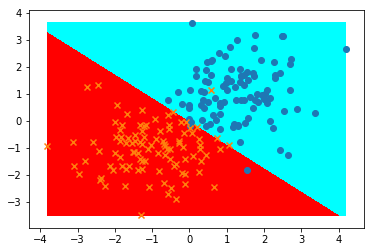

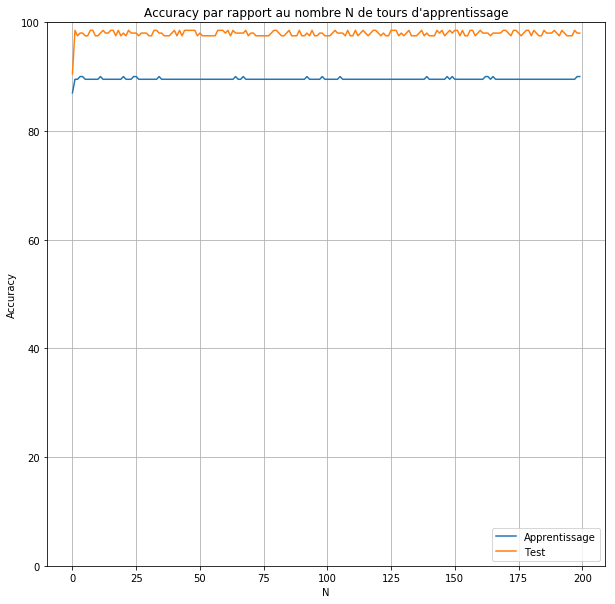

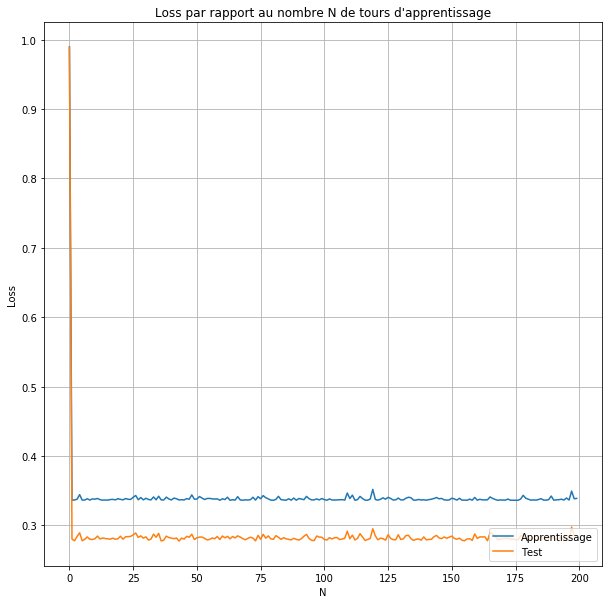

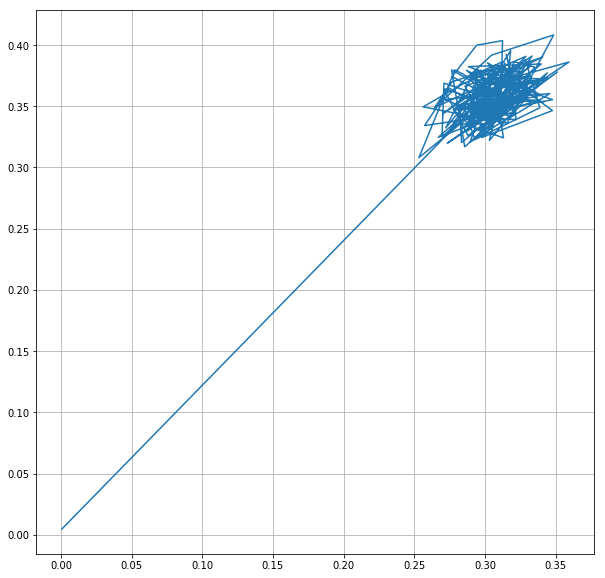

In [7]:
grad = ClassifierGradientSto(2, e)

tab_acc_learn = np.zeros(N)
tab_acc_test = np.zeros(N)
tab_loss_learn = np.zeros(N)
tab_loss_test = np.zeros(N)
tab_w = np.empty((N, 2))

for i in range(N):
    tab_acc_learn[i] += grad.accuracy(set_learn)
    tab_acc_test[i] += grad.accuracy(set_test)
    tab_loss_learn[i] = grad.loss(set_learn)
    tab_loss_test[i] = grad.loss(set_test)
    tab_w[i, :] = grad.w
    grad.train(set_learn)


    
ut.plot_frontiere(set_test,grad)
ut.plot2DSet(set_test)
print("Accuracy du algorithme de descent du gradient stochastique: " + str(grad.accuracy(set_test))+ "%")

tab_N = np.arange(N)

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(True)
ax.set_xlabel("N")
ax.set_ylabel("Accuracy")
ax.set_ylim([0, 100])
ax.plot(tab_N, tab_acc_learn, label = 'Apprentissage') 
ax.plot(tab_N, tab_acc_test, label = 'Test')

ax.legend(loc = "lower right")
ax.set_title("Accuracy par rapport au nombre N de tours d'apprentissage")

fig, cx = plt.subplots(figsize=(10, 10))
cx.grid(True)
cx.set_xlabel("N")
cx.set_ylabel("Loss")
cx.plot(tab_N, tab_loss_learn, label = 'Apprentissage') 
cx.plot(tab_N, tab_loss_test, label = 'Test')

cx.legend(loc = "lower right")
cx.set_title("Loss par rapport au nombre N de tours d'apprentissage")


fig, bx = plt.subplots(figsize=(10, 10))
bx.grid(True)
bx.plot(tab_w[:, 0], tab_w[:, 1], label = 'w');

On remarque que le perceptron avec descente de gradient stochastique a une très bonne accuracy sur cet ensemble de données, supérieure à 90%, qui est atteinte assez rapidement. Le vecteur `w` oscille mais ses oscillations sont bornées et n'ont pas beaucoup d'influence sur la prédiction du perceptron puisqu'il reste toujours dans la même direction générale par rapport à l'origine.

On teste maintenant le Classifier Gradient en Batch:

Accuracy du algorithme de descent du gradient en batch: 97.5%


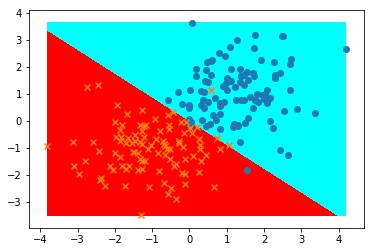

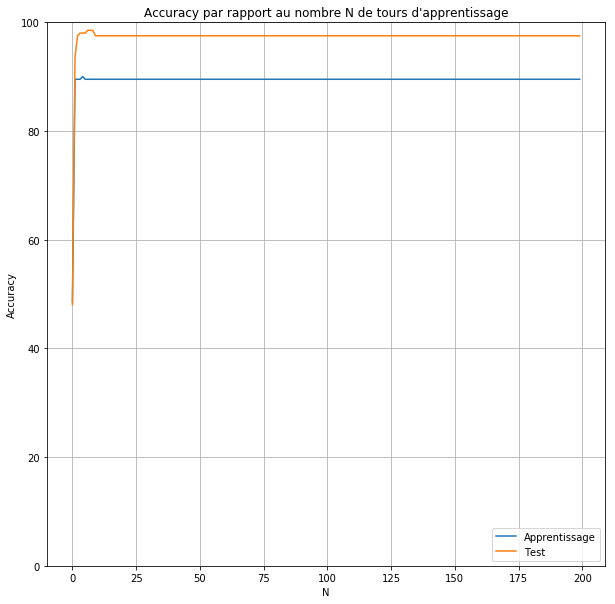

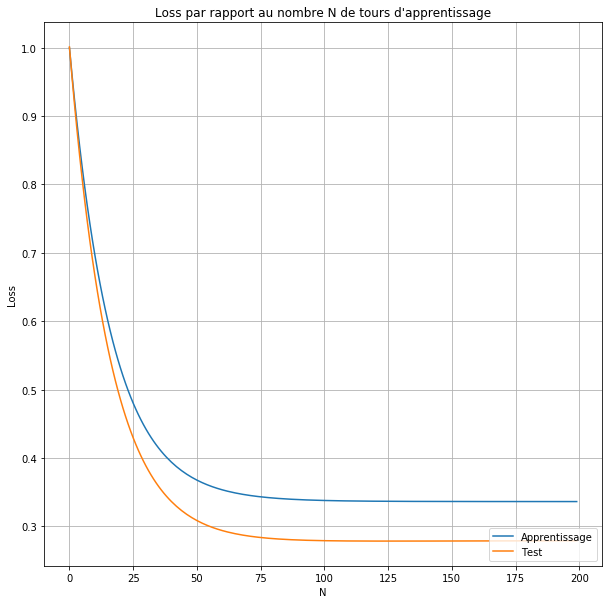

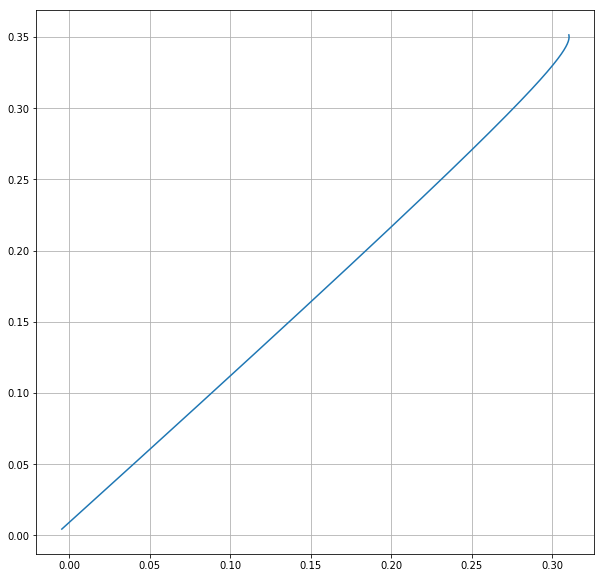

In [8]:
grad2 = ClassifierGradientBatch(2, e)

tab_acc_learn = np.zeros(N)
tab_acc_test = np.zeros(N)
tab_loss_learn = np.zeros(N)
tab_loss_test = np.zeros(N)
tab_w = np.empty((N, 2))

for i in range(N):
    tab_acc_learn[i] += grad2.accuracy(set_learn)
    tab_acc_test[i] += grad2.accuracy(set_test)
    tab_loss_learn[i] = grad2.loss(set_learn)
    tab_loss_test[i] = grad2.loss(set_test)
    tab_w[i, :] = grad2.w
    grad2.train(set_learn)


    
ut.plot_frontiere(set_test, grad2)
ut.plot2DSet(set_test)
print("Accuracy du algorithme de descent du gradient en batch: " + str(grad2.accuracy(set_test))+ "%")

tab_N = np.arange(N)

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(True)
ax.set_xlabel("N")
ax.set_ylabel("Accuracy")
ax.set_ylim([0, 100])
ax.plot(tab_N, tab_acc_learn, label = 'Apprentissage') 
ax.plot(tab_N, tab_acc_test, label = 'Test')

ax.legend(loc = "lower right")
ax.set_title("Accuracy par rapport au nombre N de tours d'apprentissage")


fig, cx = plt.subplots(figsize=(10, 10))
cx.grid(True)
cx.set_xlabel("N")
cx.set_ylabel("Loss")
cx.plot(tab_N, tab_loss_learn, label = 'Apprentissage') 
cx.plot(tab_N, tab_loss_test, label = 'Test')

cx.legend(loc = "lower right")
cx.set_title("Loss par rapport au nombre N de tours d'apprentissage")


fig, bx = plt.subplots(figsize=(10, 10))
bx.grid(True)
bx.plot(tab_w[:, 0], tab_w[:, 1], label = 'w');

On remarque que le gradient en batch donne une accuracy aussi bonne que celle du gradient stochastique, qui doit probablement correspondre à l'accuracy maximale que l'on peut avoir avec une séparation linéaire de cet ensemble de données. Cependant, le fait de calculer en batch supprime les oscillations observées dans le gradient stochastique, car il n'y a plus de choix aléatoire à faire et toutes les données sont prises avec le même poids, sans le poids plus important pour la dernière que l'on a dans le cas où `w` est modifié à chaque itération.

On a observé, dans un premier temps, que la méthode du gradient par batch ne marche pas si on implémente la mise à jour de `w` par

```python
self.w += self.e * gradient
```

En effet, le vecteur `gradient` contient la somme de tous les termes du type `(labeledSet.getY(i) - z) * elem` pour chaque entrée `i` du labeled set. Cette somme peut être très grande si le dataset est grand, ce qui veut dire que, même avec la multiplication par `self.e`, l'incrémentation de `self.w` d'une étape à l'autre était trop grande. Cela donnait une méthode divergente, avec `w` qui augmentait en norme sans arrêt et une accuracy oscillant entre 10% et 90%. Pour stabiliser la méthode, on pourrait diminuer la valeur de `self.e`, mais sa diminution devrait être d'autant plus importante qu'il y a de données dans le dataset. On a donc décidé de diviser `gradient` par la taille du dataset, et donc incrémenter `w` par

```python
self.w += self.e * gradient / labeledSet.size()
```

Cela correspond à incrémenter `w` par la moyenne des termes du type `(labeledSet.getY(i) - z) * elem`, et pas leur somme. Cela est aussi mathématiquement équivalent à incrémenter `w` par `gradient` mais diminuer `self.e` en lui divisant par la quantité de te

Maintenant on veut tester les versions kernelisés des deux Classifiers. Pour cela on crée une nouvelle ensemble de données que ne peut pas être clasifiée par une droite. On initialise un kernel aussi.

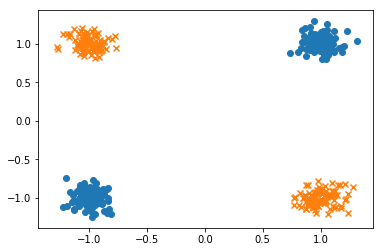

In [9]:
xor = ut.createXOR(100,0.01)

k = ut.KernelPolyMultiD()

ut.plot2DSet(xor)

On teste le Classifier Gradient Stochastique Kernelisé:

Accuracy du algorithme de descent du gradient stochastique kernelisé: 100.0%


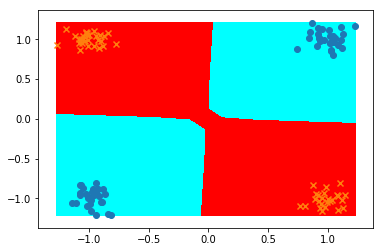

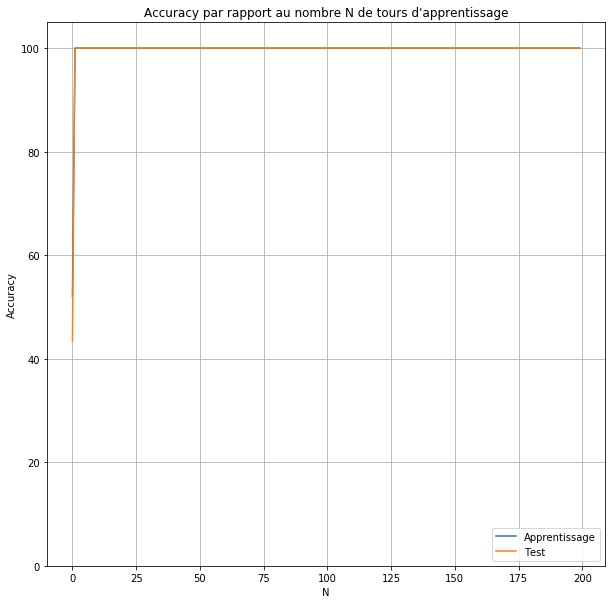

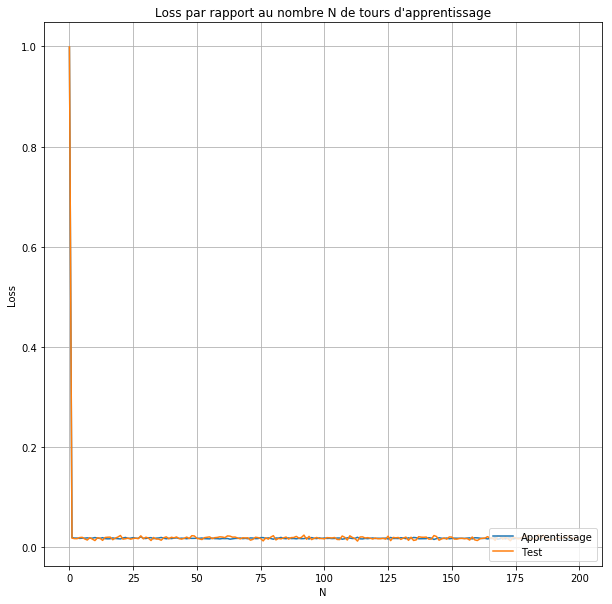

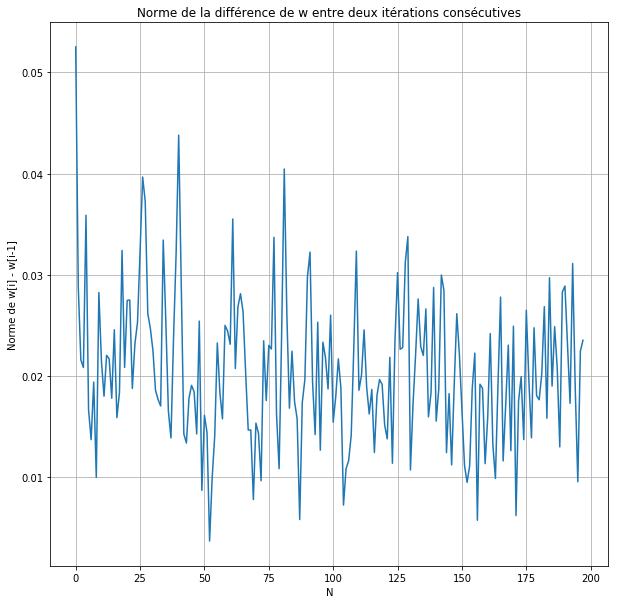

In [10]:
grad3 = ClassifierGradientStoKernel(6, e, k)

tab_acc_learn = np.zeros(N)
tab_acc_test = np.zeros(N)
tab_loss_learn = np.zeros(N)
tab_loss_test = np.zeros(N)
tab_w = np.zeros((N, 6))

for i in range(N):
    set_learn, set_test = ut.split(xor,  p_train = 0.75)
    tab_acc_learn[i] += grad3.accuracy(set_learn)
    tab_acc_test[i] += grad3.accuracy(set_test)
    tab_loss_learn[i] = grad3.loss(set_learn)
    tab_loss_test[i] = grad3.loss(set_test)
    tab_w[i, :] = grad3.w
    grad3.train(set_learn)

ut.plot_frontiere(set_test, grad3)
ut.plot2DSet(set_test)
print("Accuracy du algorithme de descent du gradient stochastique kernelisé: " + str(grad3.accuracy(set_test))+ "%")

tab_N = np.arange(N)

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(True)
ax.set_xlabel("N")
ax.set_ylabel("Accuracy")
ax.set_ylim([0, 105])
ax.plot(tab_N, tab_acc_learn, label = 'Apprentissage') 
ax.plot(tab_N, tab_acc_test, label = 'Test')

ax.legend(loc = "lower right")
ax.set_title("Accuracy par rapport au nombre N de tours d'apprentissage")


fig, cx = plt.subplots(figsize=(10, 10))
cx.grid(True)
cx.set_xlabel("N")
cx.set_ylabel("Loss")
cx.plot(tab_N, tab_loss_learn, label = 'Apprentissage') 
cx.plot(tab_N, tab_loss_test, label = 'Test')

cx.legend(loc = "lower right")
cx.set_title("Loss par rapport au nombre N de tours d'apprentissage")



fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(True)
ax.plot(np.linalg.norm(tab_w[2:, :] - tab_w[1:-1, :], axis=1))
ax.set_xlabel("N")
ax.set_title("Norme de la différence de w entre deux itérations consécutives")
ax.set_ylabel("Norme de w[i] - w[i-1]");

On teste maintenant le Classifier Gradient en Batch Kernelisé:

Accuracy du algorithme de descent du gradient stochastique kernelisé: 100.0%


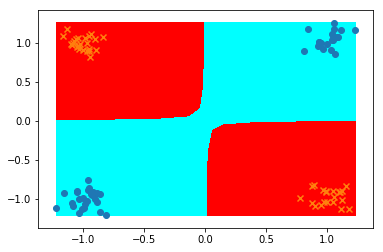

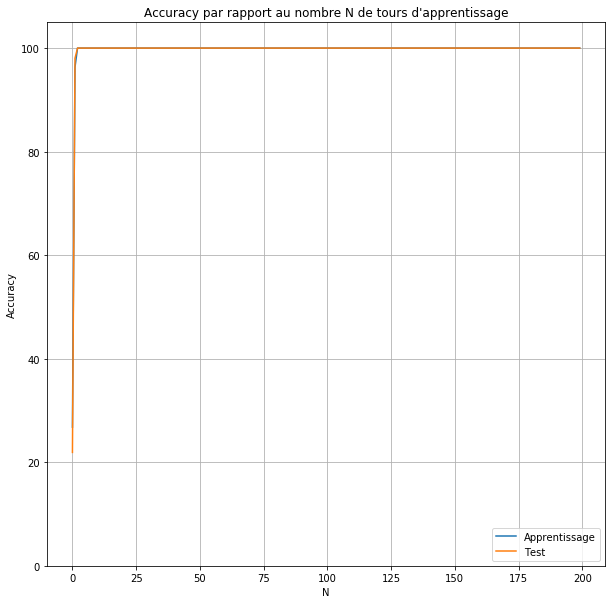

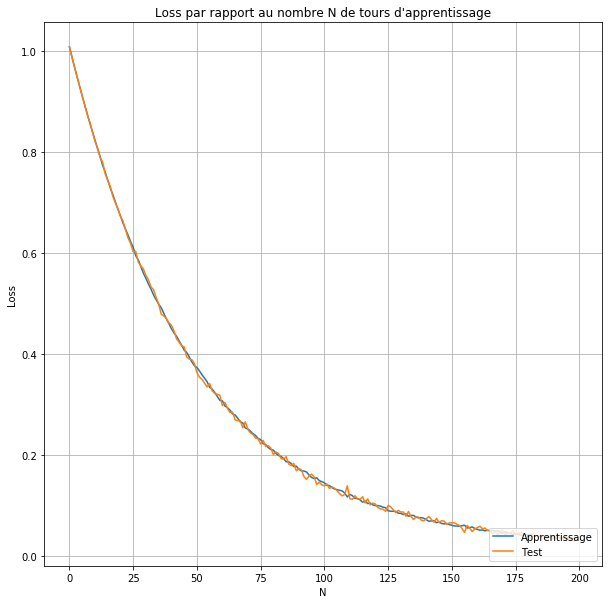

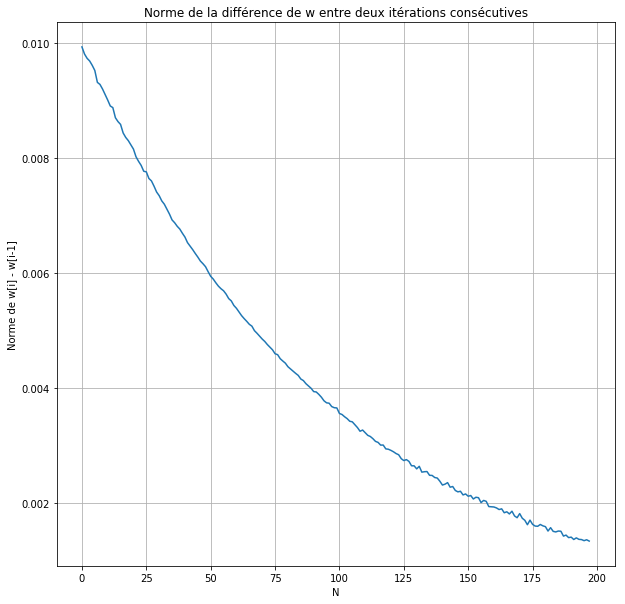

In [11]:
grad4 = ClassifierGradientBatchKernel(6, e, k)

tab_acc_learn = np.zeros(N)
tab_acc_test = np.zeros(N)
tab_loss_learn = np.zeros(N)
tab_loss_test = np.zeros(N)
tab_w = np.zeros((N, 6))

for i in range(N):
    set_learn, set_test = ut.split(xor,  p_train = 0.75)
    tab_acc_learn[i] += grad4.accuracy(set_learn)
    tab_acc_test[i] += grad4.accuracy(set_test)
    tab_loss_learn[i] = grad4.loss(set_learn)
    tab_loss_test[i] = grad4.loss(set_test)
    tab_w[i, :] = grad4.w
    grad4.train(set_learn)

ut.plot_frontiere(set_test, grad4)
ut.plot2DSet(set_test)
print("Accuracy du algorithme de descent du gradient stochastique kernelisé: " + str(grad4.accuracy(set_test))+ "%")

tab_N = np.arange(N)

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(True)
ax.set_xlabel("N")
ax.set_ylabel("Accuracy")
ax.set_ylim([0, 105])
ax.plot(tab_N, tab_acc_learn, label = 'Apprentissage') 
ax.plot(tab_N, tab_acc_test, label = 'Test')

ax.legend(loc = "lower right")
ax.set_title("Accuracy par rapport au nombre N de tours d'apprentissage")


fig, cx = plt.subplots(figsize=(10, 10))
cx.grid(True)
cx.set_xlabel("N")
cx.set_ylabel("Loss")
cx.plot(tab_N, tab_loss_learn, label = 'Apprentissage') 
cx.plot(tab_N, tab_loss_test, label = 'Test')

cx.legend(loc = "lower right")
cx.set_title("Loss par rapport au nombre N de tours d'apprentissage")



fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(True)
ax.plot(np.linalg.norm(tab_w[2:, :] - tab_w[1:-1, :], axis=1))
ax.set_xlabel("N")
ax.set_title("Norme de la différence de w entre deux itérations consécutives")
ax.set_ylabel("Norme de w[i] - w[i-1]");

On remarque que les versions kernelisées des perceptrons permettent de bien séparer les données XOR, comme attendu. Dans la version stochastique, `w` oscille beaucoup, alors que, dans la version en batch, les écarts entre deux vecteurs `w` consécutifs diminuent, suggérant une convergence de `w`.

Mise en oeuvre sur des données réelles 
-------

La mise en ouvre sur de données réelles a été aussi fait sur le complèment du TME3, sur les données sur le cancer du sein. 

# Préparation du projet

Le projet est à rendre lors de la dernière séance de TD-TME de votre groupe qui aura lieu la semaine du **16 avril**. Lors de cette dernière séance, une soutenance sera organisée afin que vous présentiez le travail réalisé et les résultats obtenus.



## Données

Les données à utiliser sont des données issues d'une base de films et de notations faites par des spectateurs:
- base MovieLens : https://grouplens.org/datasets/movielens/
- base complémentaire `Movie Industrie`: https://www.kaggle.com/danielgrijalvas/movies


<font color="RED">**ATTENTION**: la base est très volumineuse (plus d'1Go) et ne pourra pas tenir sur votre répertoire de travail des machines de TME.</font>

Dans un premier temps, vous travaillerez sur la version réduite de cette base (`ml-latest-small.zip` sur le site movilens) que vous pouvez récupérer sur les machines de TD-TME: `/users/Enseignants/marsala/3i026-2019/MovieLens-small.tgz`
Cette version contient qu'une partie des lignes de la base originale.



En salle de TD-TME, vous accéderez aux données dans les fichiers suivants (à ne pas recopier !):
- répertoire : `/users/Enseignants/marsala/3i026-2019`
- répertoire des données MovieLens version réduite : `/users/Enseignants/marsala/3i026-2019/MovieLens-small/` 
- fichier archive avec les données MovieLesns version réduite : `/users/Enseignants/marsala/3i026-2019/MovieLens-small.tgz`
- répertoire des données MovieLens : `/users/Enseignants/marsala/3i026-2019/MovieLens/` 
  Il contient les fichiers CSV que vous pouvez ouvrir directement dans le notebook.
- fichier `/users/Enseignants/marsala/3i026-2019/kaggle-movies.csv` : infos sur les films de la base Movie Industrie
   
   
  




<font color="RED" size="+1">**[Q]**</font> Réaliser des expérimentations avec la base MovieLens version réduite.

Charger les données dans un dataframe, afficher des informations statistiques sur les données, commencer à réfléchir comment appliquer les classifieurs vus dans les séances précédentes sur ces données...

Comme on travaille sur un ordinateur personnel sans souci d'espace de stockage, on a téléchargé l'ensemble de la base de données, qui a été mise dans le dossier `data`.

In [12]:
path_small = "../data/MovieLens-small/"
path_full = "../data/MovieLens/"
path = path_small

movies_pd = pd.read_csv(path + "movies.csv", index_col = 0)
movies_pd.head()
#movies_pd.describe()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


Pour simplifier le traitement du dataset, on commence par transformer la colonne `genres`. Le fichier `README.txt` donne la liste de tous les genres possibles. On rajoute une colonne pour chaque genre et on la remplit avec `1` si le film correspondant a été classifié dans ce genre, `-1` sinon.

In [13]:
genres = ["Action", "Adventure", "Animation", "Children", "Comedy", \
          "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", \
          "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", \
          "Western", "(no genres listed)"]

for g in genres:
    movies_pd[g] = movies_pd.apply(lambda r: 2*int(g in r["genres"]) - 1, axis=1)

On rajoute aussi une colonne au dataset avec l'année de sortie du film récupéré à partir de son titre et on efface l'année du titre.

In [14]:
def get_year(r):
    match = re.match("(.*)\s*\((\d+)\)", r["title"])
    if match:
        return match.group(2)
    
def get_title_without_year(r):
    match = re.match("(.*)\s*\((\d+)\)", r["title"])
    if match:
        return match.group(1)
    else:
        return r["title"]

movies_pd["Year"] = movies_pd.apply(get_year, axis = 1)
movies_pd["title"] = movies_pd.apply(get_title_without_year, axis = 1)

In [15]:
movies_pd.head()

,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),Year
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,-1,1,1,1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1995
2,Jumanji,Adventure|Children|Fantasy,-1,1,-1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1995
3,Grumpier Old Men,Comedy|Romance,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1995
4,Waiting to Exhale,Comedy|Drama|Romance,-1,-1,-1,-1,1,-1,-1,1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1995
5,Father of the Bride Part II,Comedy,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1995


On importe maintenant le fichier avec les ratings.

In [16]:
ratings_pd = pd.read_csv(path + "ratings.csv")
ratings_pd.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


On rajoute quelques statistiques des notes au dataframe des films.

In [17]:
movies_pd["Average rating"] = ratings_pd.groupby("movieId")["rating"].mean()
movies_pd["Number of ratings"] = ratings_pd.groupby("movieId")["rating"].count()

In [18]:
movies_pd.head()

,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),Year,Average rating,Number of ratings
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,-1,1,1,1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1995,3.920930,215.0
2,Jumanji,Adventure|Children|Fantasy,-1,1,-1,1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1995,3.431818,110.0
3,Grumpier Old Men,Comedy|Romance,-1,-1,-1,-1,1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,1995,3.259615,52.0
4,Waiting to Exhale,Comedy|Drama|Romance,-1,-1,-1,-1,1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,1995,2.357143,7.0
5,Father of the Bride Part II,Comedy,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,1995,3.071429,49.0
